In [94]:
import gc
gc.collect()

0

In [59]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment


from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
from sklearn import metrics
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import nltk


# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


In [60]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('gpu')))
# torch.cuda.is_available()

Num GPUs Available:  0


In [61]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [63]:
# experiment.end()

In [64]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

In [65]:
def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    
    return words

scaler = MinMaxScaler()

In [66]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)


Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [67]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [68]:
# df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# # Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# MaxMin_df.head()

In [69]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [70]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

In [71]:
# Merging columns
# df2['content'] = df2['title'] + df2['text']
# df2

In [72]:
df2 = df2[df2['text'].map(len) >= 1]
#Reset index
df2 = df2.reset_index().drop("index", axis=1)
df2


,title,text,type
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real
...,...,...,...
19800,"[Alabama, Lawmaker, Same, Couples, Don, Deserv...","[Most, conservatives, oppose, marriage, equali...",real
19801,"[GOP, Senator, David, Perdue, Jokes, About, Pr...","[The, freshman, senator, Georgia, quoted, scri...",real
19802,"[State, Department, says, find, emails, Clinto...","[The, State, Department, told, Republican, Nat...",real
19803,"[In, Ethiopia, Obama, seeks, progress, peace, ...","[ADDIS, ABABA, Ethiopia, Obama, convened, meet...",real


type
fake    11731
real     8074
Name: title, dtype: int64


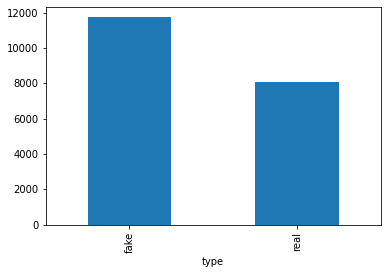

In [73]:
# How many fake and real articles?
print(df2.groupby(['type'])['title'].count())
df2.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

In [74]:
model_embed = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [75]:
vocab_length = len(model_embed.key_to_index.keys())

In [76]:
# Embedding Matrix
embed_mat = np.zeros((50000,300))
for i, e in model_embed.key_to_index.items():
    # embed_mat[model_embed.key_to_index['e']] = model_embed[i]
    embed_mat[model_embed.get_index('e')] = model_embed[i]


In [77]:
# Applying it to the columns 

df2['title'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['title'] if x in model_embed.key_to_index], axis=1)
df2['text'] = df2.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['text'] if x in model_embed.key_to_index], axis=1)
# df2['content'] = df2.apply(lambda r: [model_embed.key_to_index[x] for x in r['content'] if x in model_embed.key_to_index], axis=1)


Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [78]:
# One-hot encoding
encoder = LabelBinarizer().fit(list(df2['type']))
df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [79]:
df2

,title,text,type
0,"[332, 6117, 13034, 11062, 20257, 9193, 446]","[128, 2379, 318, 13034, 9413, 1631, 242, 957, ...",[1]
1,"[13034, 2124, 44625, 442, 5353, 51, 7754, 8808...","[6117, 4883, 13034, 3113, 2826, 4605, 1927, 33...",[1]
2,"[6117, 13034, 49031, 1790, 659, 11977, 553, 94...","[446, 6117, 4883, 13034, 1790, 659, 16780, 177...",[1]
3,"[176192, 1035, 3789, 316, 13034, 12441, 3337, ...","[741, 615, 1924, 65, 675, 1639, 469, 8793, 112...",[1]
4,"[282726, 14896, 13034, 26994, 17785, 11977, 17...","[446, 6117, 4883, 13034, 783, 282726, 831, 148...",[1]
...,...,...,...
19800,"[2625, 47190, 14968, 22328, 4119, 115896, 1496...","[1214, 6555, 5472, 2724, 10729, 12687, 6484, 3...",[1]
19801,"[2751, 4301, 689, 19370, 82238, 1523, 94624, 4...","[7, 2779, 4264, 1742, 2717, 38413, 168, 1956, ...",[1]
19802,"[268, 423, 115, 359, 9451, 1820, 1735, 3803]","[7, 268, 423, 162, 917, 430, 1468, 75, 359, 94...",[1]
19803,"[70, 9711, 494, 3786, 1463, 1356, 371, 1063, 1...","[1538939, 1151610, 9711, 494, 13595, 349, 618,...",[1]


In [80]:
# Padding:----
def pad_array(array, token_len):
    diff_token = token_len - len(array)
    if(diff_token < 0):
        array = array[:token_len] 
    else:
        array += [0]*diff_token 
        
    return array 

tokens_numbers_text = df2.swifter.apply(lambda row: len(row['text']), axis = 1)
max_tokens_text = int(np.mean(tokens_numbers_text) + 2 * np.std(tokens_numbers_text))

tokens_numbers_title = df2.swifter.apply(lambda row: len(row['title']), axis = 1)
max_tokens_title = int(np.mean(tokens_numbers_title) + 2 * np.std(tokens_numbers_title))
print(max_tokens_text,max_tokens_title)    

# # Check the highest length of text and title:
# max_tokens_text = 13000
# max_tokens_title = 48

# Shifting all to a new dataframe
df3 = df2.loc[:,['title','text','type']]


Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

1365 15


In [81]:
df3['text'] = df2.swifter.apply(lambda r: pad_array(r['text'], max_tokens_text) , axis=1)
df3['title'] = df2.swifter.apply(lambda r: pad_array(r['title'], max_tokens_title) , axis=1)


# df3['text'] = list(pad_sequences((df2['text']), maxlen=max_tokens_text,padding='post'))
# df3['title'] = list(pad_sequences(df2['title'], maxlen=max_tokens_title,padding='post'))

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [82]:
#Python object serialized
df3.to_pickle('./model_data.pickle')

In [83]:
data_pickle = pd.read_pickle('./model_data.pickle')
data_pickle = data_pickle.dropna()

In [84]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data_pickle[['text', 'title']], data_pickle['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
 

train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist())
             ]

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist())
             ]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text'].tolist())
             ]    


In [85]:
print(train_fit[0].shape)
print(train_fit[1].shape)
# print(valid_fit.shape)
# print(test_fit.shape)

(12675, 15)
(12675, 1365)


In [86]:
gg=np.asarray(y_train.tolist())
print(gg.shape)

(12675, 1)


In [87]:
from numpy.random import seed

seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [88]:
embedding_dims=300
num_steps = 150

In [89]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
# inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300)(title_input)
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,input_length=num_steps,trainable=False)(title_input)

#Added
x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu')(inp1)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_Text
text_input = k.layers.Input(shape=(max_tokens_text,))
# inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300)(text_input)
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,input_length=num_steps,trainable=False)(text_input)

x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)

#Added
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Text')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model = k.models.Model(inputs=[title_input, text_input], outputs=[out])

model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1365)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1365, 300)    900000000   ['input_2[0][0]']                
                                                                                              

In [90]:
# #input_title
# title_input = k.layers.Input(shape=(max_tokens_title,), name='title_input')
# inp = k.layers.Embedding(output_dim=300, input_dim=50000,)(title_input)

# x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(inp)
# x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
# x = k.layers.Flatten()(x)
# x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

# #input_content
# content_input = k.layers.Input(shape=(max_tokens_text,), name='content_input')
# inp2 = k.layers.Embedding(output_dim=300, input_dim=50000)(content_input)
# x2 = k.layers.Conv1D(filters = 40, kernel_size = 16, strides = 2, activation='relu', name='Conv1Content')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool1Content')(x2)

# #Added
# x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
# x2 = k.layers.Flatten()(x2)
# x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)


# #Merge
# x = k.layers.concatenate([x, x2])

# #Common part
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
# out = k.layers.Dense(4, activation='softmax')(x)


# #Build model
# model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

# model.compile(k.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['acc'])

# model.summary()

In [91]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=20,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.1)], 
        validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/20
100/100 [==============================] - 21s 186ms/step - loss: 0.8356 - acc: 0.7118 - val_loss: 0.5592 - val_acc: 0.8220
Epoch 2/20
100/100 [==============================] - 18s 185ms/step - loss: 0.4504 - acc: 0.8539 - val_loss: 0.8031 - val_acc: 0.6967
Epoch 3/20
100/100 [==============================] - 18s 185ms/step - loss: 0.3277 - acc: 0.8970 - val_loss: 0.3910 - val_acc: 0.8653
Epoch 4/20
100/100 [==============================] - 19s 186ms/step - loss: 0.2473 - acc: 0.9294 - val_loss: 0.3583 - val_acc: 0.8896
Epoch 5/20
100/100 [==============================] - 18s 185ms/step - loss: 0.1672 - acc: 0.9644 - val_loss: 0.3657 - val_acc: 0.8940
Epoch 6/20
100/100 [==============================] - 18s 184ms/step - loss: 0.1284 - acc: 0.9761 - val_loss: 0.3770 - val_acc: 0.8959


In [92]:
# # Confusion Matrix of SVM
# cm = metrics.confusion_matrix(y_test, prediction)
# plot_confusion_matrix(cm, classes=['Fake', 'Real'])